Demonstration notebook to show how to upload files to a Drive, and then how to call hugs functions that could process those files subject to user authorisation

In [71]:
import sys
sys.path.insert(0, "../../../acquire")

In [72]:
from Acquire.Client import User, Drive, Service, StorageCreds, PAR, Authorisation

In [73]:
base_url = "https://hugs.acquire-aaai.com/t"

First, login as a valid hugs user...

In [74]:
user = User(username="gareth", identity_url="%s/identity" % base_url)

In [75]:
response = user.request_login()

Login by visiting: https://login.acquire-aaai.com?id=a0-a6/74.c1.cd.54
(please check that this page displays the message 'white mice stand noisily')


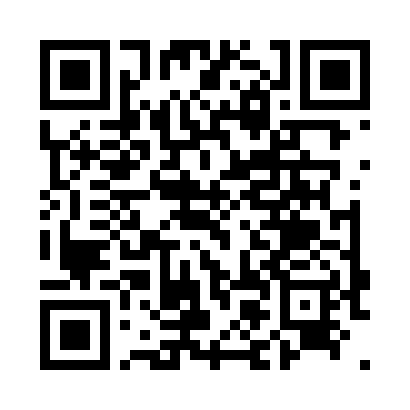

In [77]:
from Acquire.Client import create_qrcode
create_qrcode(response["login_url"])

In [79]:
user.wait_for_login()

True

Next create the credentials used to connect to the storage service to create/get a drive

In [80]:
creds = StorageCreds(user=user, service_url="%s/storage" % base_url)

The below line will give you a handle to a drive called 'test_drive' - this will be automatically created if it doesn't exist

In [81]:
drive = Drive(creds=creds, name="test_drive")

Next, we upload a file to this drive. This returns the metadata about the file, from which we can get the universally-resolvable file location

In [82]:
filemeta = drive.upload("test_file.txt")

In [83]:
filemeta.location()

acquire_file://a561b6b2-05f0-4729-b16d-31345344178a@a0-b1/dGVzdF9maWxlLnR4dA==/2019-07-11T15:42:07.906067/236ab83b

Create a pre-authenticated request that can grant temporary access to this file to whoever holds a copy. This PAR is for a specified location, and grants access with the same permissions as the passed user (defaults to read-only)

In [84]:
par = PAR(location=filemeta.location(), user=user)

In [85]:
par.to_data()

{'location': {'drive_guid': 'a561b6b2-05f0-4729-b16d-31345344178a@a0-b1',
  'encoded_filename': 'dGVzdF9maWxlLnR4dA==',
  'version': '2019-07-11T15:42:07.906067/236ab83b'},
 'aclrule': 'reader',
 'expires_datetime': '2019-07-12T15:42:08.205116',
 'uid': 'ec02bf55-945f-4d2c-ba25-d21aa95e059b'}

Now get a handle to the HUGS service.

In [ ]:
hugs = Service(service_url="%s/hugs" % base_url)

We will create an authorisation to call the 'hello' function. We will pass this, together with the PAR to the 'hello' function. The PAR is protected with an internal secret. To share this, we need to encrypt the secret using the hugs service and send that too. Only the hugs service is capable of decrypting the resulting 'par_secret'

In [ ]:
auth = Authorisation(resource="hello", user=user)

In [ ]:
par_secret = hugs.encrypt_data(par.secret())

In [ ]:
args = {"authorisation": auth.to_data(),
        "file_par": par.to_data(),
        "par_secret": par_secret}

Finally(!) we can call the function. This will say hello, and will also download the passed file and return its contents to us in 'response'

In [ ]:
response = hugs.call_function(function="hello", args=args)

In [ ]:
response

The code that performs the "hello" function is copied below;

```python
from Acquire.Client import Authorisation, PAR
from Acquire.Service import get_this_service


def hello(args):
    try:
        name = args["name"]
    except:
        name = "World"

    try:
        authorisation = Authorisation.from_data(args["authorisation"])
    except:
        authorisation = None

    try:
        par = PAR.from_data(args["file_par"])
    except:
        par = None

    try:
        par_secret = args["par_secret"]
    except:
        par_secret = None

    if authorisation:
        authorisation.verify("hello")
        name = "%s [authorised]" % authorisation.user_guid()

    if name == "no-one":
        raise PermissionError(
            "You cannot say hello to no-one!")

    greeting = "Hello %s" % name

    result = {"greeting": greeting}

    if par:
        # we need the hugs service with private access so that
        # we can decrypt the par_secret
        hugs = get_this_service(need_private_access=True)
        par_secret = hugs.decrypt_data(par_secret)

        # resolve the par to get the underlying file
        # (note that pars can be for files or directories)
        file = par.resolve(secret=par_secret)
        result["file"] = str(file)

        # now download the file to the /tmp directory - this will
        # time out if you don't specify the directory as the current
        # directory is read-only - the return value is the actual
        # name of the file that has been downloaded
        filename = file.download(dir="/tmp")
        result["filename"] = filename

        # here I am just reading the file to return it to you,
        # just to show that the file was correctly uploaded
        lines = open(filename).readlines()
        result["uploaded"] = lines

    return result
```

Always remember to log out from the user at the end of the notebook. User's will auto-logout on destruction, and will also log out after a period of time, but it is still good practice

In [ ]:
user.logout()